In [29]:
from aiida.backends.utils import load_dbenv, is_dbenv_loaded

if not is_dbenv_loaded():
    load_dbenv()

from aiida.work.run import run, submit
from aiida.work.workfunction import workfunction
from aiida.work.workchain import WorkChain, ToContext, while_, Outputs, if_, append_
from aiida.orm.data.base import Float, Str, NumericType, BaseType, Int, Bool, List
from aiida.orm.code import Code
from aiida.orm import load_node
import numpy as np
import matplotlib.pyplot as plt

import pymatgen
import numpy as np
from aiida.orm.data.upf import UpfData
from aiida.common.exceptions import NotExistent
from aiida.orm.data.upf import get_pseudos_from_structure
from aiida.orm.data.parameter import ParameterData
from aiida.orm.data.structure import StructureData
from aiida.orm.data.array.kpoints import KpointsData
from aiida.orm.data.array import ArrayData
from aiida.orm.data.folder import FolderData
from aiida.orm.data.remote import RemoteData
from aiida.orm.code import Code
from aiida.orm.data.singlefile import SinglefileData
from aiida.orm.group import Group

from aiida.work.workchain import WorkChain, ToContext, if_, while_, Outputs, if_, append_

from aiida.orm.data.base import Float, Str, NumericType, BaseType, Int, Bool, List

from aiida_quantumespresso.workflows.pw.base import PwBaseWorkChain
from aiida_quantumespresso.workflows.pw.relax import PwRelaxWorkChain
from aiida_quantumespresso.calculations.pp import PpCalculation
from aiida_quantumespresso.calculations.pw import PwCalculation
from aiida_defects.tools.structure_manipulation import create_suitable_inputs_noclass



In [37]:
#@workfunction
def dielectric_profile_along_axis(structure_a,
                                  structure_b,
                                  potential_a,
                                  potential_b,
                                  structure_saw,
                                  sawtooth,
                                  axis,
                                  sigma=-100.):
    """
    Compute dielectric constant profile along one axis.
    Can be used for calculation on slabs
    :param structure_a/b: StructureData object containing the (optimized) structure in the absence or in presence
    of  uniform electric field, respectively
    :param potential_a/b: 3D-FFT grid  obtained from the read_grid function in both cases
    :param E_0: Float with the intensity of the applied external field in eV
    :param axis: Str with possible values "x", "y", "z" to indicate the direction along which epsilon is computed
    :param sigma: standard deviation of the gaussian kernel in angstrom
    :return epsilon: ArrayData object with the dielectric constant profile. epislon will be the low frequency 
    (epsilon_zero) if  atoms are optimized, or the high frequency epsilon_inf if the position are fixed
    References: Sundaraman and Ping JCP 146 104109 (2017), Pham  PRB 84, 045308 (2011)
    
    epsilon = (dV^saw/dz)/(dDektaV^scf/dz)
    
    NOTES:
    - It works correctly only if structure_a and structure_b have the same lenght along
    the direction along which the difference is computed (it is ok we only do relax not vc-relax)
    - If sigma it is not specified a value that is equal to half of the largest distance between 
    neighboring planes will be used. See (Pham et all.). However this can be very large.
    - PLEASE DO NOT PUT THE STRUCTURE AT THE EDGES OF THE SLAB!! 
    """
    from scipy.ndimage.filters import gaussian_filter
    from math import sqrt
    from mpmath import nint
    from scipy import signal


    #Computing the planar avareged electrostatic potential V along the axis 
    V_a = planar_average(potential_a, structure_a, str(axis), npt=400)
    V_b = planar_average(potential_b, structure_b, str(axis), npt=400)
    E = planar_average(sawtooth, structure_saw, str(axis), npt=400)
    #Computing Delta V
    Vdiff = V_a['average'] - V_b['average']
    ax = V_a['ax']


    #Identifying position of the slab/vacuum interface using the coordinates of the outermost atoms
    cell=structure_a.cell
    coords=[]
    if axis == 'x':
        lenght=(sqrt(cell[0][0]**2 + cell[0][1]**2 +cell[0][2]**2))
        for site in structure_a.sites:
            coords.append(float(site.position[0] - nint(site.position[0] / lenght) * lenght))

    if axis == 'y':
        lenght=(sqrt(cell[1][0]**2 + cell[1][1]**2 +cell[1][2]**2))
        for site in structure_a.sites:
            coords.append(flaot(site.position[1] - nint(site.position[1] / lenght) * lenght))
    if axis == 'z':
        lenght=(sqrt(cell[2][0]**2 + cell[2][1]**2 +cell[2][2]**2))
        for site in structure_a.sites:
            coords.append(float(site.position[2] - nint(site.position[2] / lenght) * lenght))

    coords = sorted(coords, key=int)

    vacuum_max = None
    vacuum_min = None
    plane_dists = []

    for i in range(len(coords)-1):
        plane_dists.append(abs(coords[i]-coords[i+1]))
        print i, coords[i], coords[i+1], abs(coords[i]-coords[i+1])
        if abs(coords[i]-coords[i+1]) > 5.:
            vacuum_max = coords[i+1]
            vacuum_min = coords[i]

    if vacuum_max == None or vacuum_min == None:
        vacuum_max = max(coords)
        vacuum_min = min(coords) + lenght

    #print vacuum_max, vacuum_min   

    vacuum_center = (vacuum_max+vacuum_min)*0.5
    dist=abs(vacuum_max - vacuum_center)
    smooth_percent = dist*0.85

    lim1= vacuum_center - smooth_percent
    lim2= vacuum_center + smooth_percent
    #print "lim1, lim2", lim1, lim2


    #Computing Delta_V derivative
    der_Vdiff = differentiator(ax, Vdiff)

    #Computing Sawtooth potential derivative
    der_E = differentiator(E['ax'], E['average'])

    #Calculating epsilon
    eps = der_E/der_Vdiff

    #Imposing that in the vacuum region epsilon is equal to 1:
    for i in range(len(ax)):
        if ax[i] > lim1 and ax[i] < lim2:
            eps[i] = 1.0


    #Smoothing epsilon with Gaussian kernel
    ncol=len(eps)
    if sigma == -100.:
        sigma = max(plane_dists)*0.5
    sigma *= ncol/lenght

    #print "SIGMA", sigma
    kernel = signal.gaussian(ncol, sigma)
    kernel /= kernel.sum()
    epsilon = signal.fftconvolve(eps, kernel, mode='same')

    #Storing the dielectric profile into an 2D ArrayData object with the axis and dielectric constant values
    profile = np.vstack((ax, epsilon)).T
    slabeps = ArrayData()
    slabeps.set_array('epsilon', profile)

    #Storing the profile also into a file
    plt.plot(ax,epsilon)
    plt.xlabel(str(axis)+ur' (\u00c5)', fontsize=13)
    plt.ylabel(r'$\epsilon$('+str(axis)+')', fontsize=12)
    plt.savefig(str(structure_a.pk)+'_epsilon.pdf')
    plt.show()
    return slabeps



In [38]:
from aiida_defects.pp.pp import PpWorkChain
from aiida_defects.pp.fft_tools import planar_average, read_grid, differentiator

class SlabEpsilonSawtoothWorkChain(WorkChain):
    """
    WorkChain to calculate the dielectric constant of a slab structure within the Finite Electric Field approach 
    and a sawtooth potential. Both low and high frequency dielectric constant value can be obtained
    TODO:
    -update dielectric constant profile
    -dielectric profile function should be workfunction. this would require to change the output 
    of the planar average function
    - change to compute low_frequency. this require cvhanging the Ppworkchain commenting the line for scf
      and update structure 
      
    NOTES:
    - It works correctly only if structure_a and structure_b have the same lenght along
    the direction along which the difference is computed (it is ok we only do relax not vc-relax)
    - If sigma it is not specified a value that is equal to half of the largest distance between 
    neighboring planes will be used. See (Pham et all.). However this can be very large.
    - PLEASE DO NOT PUT THE STRUCTURE AT THE EDGES OF THE SLAB!! 
    """
    @classmethod
    def define(cls, spec):
        super(SlabEpsilonSawtoothWorkChain, cls).define(spec)
        spec.input("structure",valid_type=StructureData)
        spec.input("code_pw",valid_type=Str,required=False)
        spec.input("code_pp",valid_type=Str,required=False)
        spec.input("pseudo_family",valid_type=Str, required = False)
        spec.input('options', valid_type=ParameterData)
        spec.input("settings", valid_type=ParameterData)
        spec.input("kpoints", valid_type=KpointsData, required = False)
        spec.input('parameters', valid_type=ParameterData, required = False)
        spec.input('magnetic_phase', valid_type=Str,required=False, default=Str('NM'))
        spec.input('B_atom', valid_type=Str,required=False)
        spec.input('hubbard_u', valid_type=ParameterData, required=False, default=ParameterData(dict={}))
        spec.input('epsilon_type', valid_type=Str, required=False, default=Str('high-frequency'))
        spec.input('eamp', valid_type=Float, required=False, default=Float(0.001))
        spec.input('eopreg', valid_type=Float, required=False, default=Float(0.01))
        spec.input('emaxpos', valid_type=Float, required=False, default=Float(0.75))
        spec.input('edir', valid_type=Int, required=False, default=Int(3))
        spec.input('sigma', valid_type=Float, required=False, default=Float(0.5))
        spec.outline(
            cls.initializing_e0,
            cls.run_ppworkchain_e0,
            cls.initializing_e1,
            cls.run_ppworkchain_e1,
            cls.initializing_e1_saw,
            cls.run_ppworkchain_e1_saw,
            cls.retrieve_potentials,
            cls.compute_epsilon_profile,
            )
        spec.dynamic_output()
    def initializing_e0(self):
        """
        Initializing inputs for the first calculation with a field amplitude of 0.0 a.u.
        """

        self.ctx.parameters_pp = ParameterData(dict={'INPUTPP': {'plot_num' : 11,
                                                                }})
        parameters = self.inputs.parameters.get_dict()
        if str(self.inputs.epsilon_type) == 'high-frequency':
            parameters['CONTROL']['calculation'] = 'scf'
        elif str(self.inputs.epsilon_type) == 'low-frequency':
            parameters['CONTROL']['calculation'] = 'relax'
        parameters['CONTROL']['tefield'] = True
        parameters['CONTROL']['dipfield'] = True
        #parameters['ELECTRON']['conv_thr'] = 1e-10
        parameters['SYSTEM']['edir'] = int(self.inputs.edir)
        parameters['SYSTEM']['emaxpos'] = float(self.inputs.emaxpos)
        parameters['SYSTEM']['eopreg'] = float(self.inputs.eopreg)
        parameters['SYSTEM']['eamp'] = 0.0#int(self.inputs.eamp)
        self.ctx.parameters=ParameterData(dict=parameters)

        self.ctx.inputs_e0 = {'structure' : self.inputs.structure,
                      'code_pw' : self.inputs.code_pw,
                      'pseudo_family' : self.inputs.pseudo_family,
                      'kpoints' : self.inputs.kpoints,
                      'parameters' : self.ctx.parameters,
                      'parameters_pp' : self.ctx.parameters_pp,
                      'settings' : self.inputs.settings,
                      'options' : self.inputs.options,
                      'code_pp' : self.inputs.code_pp,
                      'pw_calc' : Bool(True),
                      #'B_atom' : self.inputs.B_atom,
                      #'magnetic_phase' : self.inputs.magnetic_phase,
                     }

    def run_ppworkchain_e0(self):
        """
        Running PpWorkChain to compute the electrostatic potential (V0) for tha case in which the amplitude
        if the applied field is 0 a.u.
        """

        running = submit(PpWorkChain,**self.ctx.inputs_e0)
        self.report('Launching PpWorkChain for a FEF calculation with amplitude 0.0 a.u.. pk value {}'.format(
                                                                                                    running.pid))
        return ToContext(ppcalc_e0= running)
    def initializing_e1(self):
        """
        Initializing inputs for the  calculation with a field amplitude different from 0.0 a.u.
        """
        parameters_pp = ParameterData(dict={'INPUTPP': {'plot_num' : 11,
                                                                }})
        parameters = self.inputs.parameters.get_dict()

        if str(self.inputs.epsilon_type) == 'high-frequency':
            parameters['CONTROL']['calculation'] = 'scf'
        elif str(self.inputs.epsilon_type) == 'low-frequency':
            parameters['CONTROL']['calculation'] = 'relax'
        parameters['CONTROL']['tefield'] = True
        parameters['CONTROL']['dipfield'] = True
        #parameters['ELECTRON']['conv_thr'] = 1e-10
        parameters['SYSTEM']['edir'] = int(self.inputs.edir)
        parameters['SYSTEM']['emaxpos'] = float(self.inputs.emaxpos)
        parameters['SYSTEM']['eopreg'] = float(self.inputs.eopreg)
        parameters['SYSTEM']['eamp'] = float(self.inputs.eamp)
        self.ctx.parameters_e1=ParameterData(dict=parameters)

        self.ctx.inputs_e1 = {'structure' : self.inputs.structure,
                      'code_pw' : self.inputs.code_pw,
                      'pseudo_family' : self.inputs.pseudo_family,
                      'kpoints' : self.inputs.kpoints,
                      'parameters' : self.ctx.parameters_e1,
                      'parameters_pp' : parameters_pp,
                      'settings' : self.inputs.settings,
                      'options' : self.inputs.options,
                      'code_pp' : self.inputs.code_pp,
                      'pw_calc' : Bool(True),
                      #'B_atom' : self.inputs.B_atom,
                      #'magnetic_phase' : self.inputs.magnetic_phase,
                     }

    def run_ppworkchain_e1(self):
        """
        Running PpWorkChain to compute the electrostatic potential (V1) for the case in which the amplitude
        if the applied field is different from 0 a.u.
        """
        running = submit(PpWorkChain,**self.ctx.inputs_e1)
        self.report('Launching PpWorkChain for a FEF calculation with amplitude {} a.u.. pk value {}'.format(
                                                                                                    self.inputs.eamp,
                                                                                                    running.pid))
        return ToContext(ppcalc_e1= running)

    def initializing_e1_saw(self):
        """
        Initializing inputs for the calculation of the sawtooth potential.
        The PpWorkChain is  run using the wavefunction and all the necessary information  taken from 
        the PwCalculation performed in the previous step.
        """


        parameters_pp = ParameterData(dict={'INPUTPP': {'plot_num' : 12,
                                                                }})
        parent_folder = self.ctx.ppcalc_e1.out.remote_folder

        self.ctx.inputs_e1_saw = {'structure' : self.inputs.structure,
                                  'parameters_pp' : parameters_pp,
                                  'settings' : self.inputs.settings,
                                  'options' : self.inputs.options,
                                  'code_pp' : self.inputs.code_pp,
                                  'pw_calc' : Bool(False),
                                  'remote_folder' : parent_folder,

                     }

    def run_ppworkchain_e1_saw(self):
        """
        Running the PpWorkChain to calculate the sawtooth potential (V_saw)
        """
        running = submit(PpWorkChain,**self.ctx.inputs_e1_saw)
        self.report('Launching PpWorkChain to compute the sawtooth potential. pk value {}'.format(running.pid))
        return ToContext(ppcalc_e1_saw= running)

    def retrieve_potentials(self):
        """
        Retreiving the 3D-FFT grid for each of the three potentials and storing the grids in the DB
        """
        self.ctx.grid_e0 = read_grid(self.ctx.ppcalc_e0.out.retrieved)
        self.ctx.grid_e1 = read_grid(self.ctx.ppcalc_e1.out.retrieved)
        self.ctx.grid_e1_saw = read_grid(self.ctx.ppcalc_e1_saw.out.retrieved)
        self.out('fft_grid_V0', self.ctx.grid_e0['fft_grid'])
        self.out('fft_grid_V1', self.ctx.grid_e1['fft_grid'])
        self.out('fft_grid_V_saw', self.ctx.grid_e1_saw['fft_grid'])

    def compute_epsilon_profile(self):
        """
        Computing the dielectric constant profile epsilon=(dV_saw/dz)/(d(V1-V0)/dz)
        """
        if int(self.inputs.edir) == 1:
            axis = 'x'
        elif int(self.inputs.edir) == 2:
            axis = 'y'
        elif int(self.inputs.edir) == 3:
            axis = 'z'

        epsilon = dielectric_profile_along_axis(self.inputs.structure,
                                      self.inputs.structure,
                                      self.ctx.grid_e0,
                                      self.ctx.grid_e1,
                                      self.inputs.structure,
                                      self.ctx.grid_e1_saw,
                                      axis,
                                      float(self.inputs.sigma))
        self.out('epsilon', epsilon)
        self.report("SlabEpsilonSawtoothWorkChain completed succesfully")


12/12/2018 05:39:28 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162668|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e0]: Launching PpWorkChain for a FEF calculation with amplitude 0.0 a.u.. pk value 162672
12/12/2018 05:46:19 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162668|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1]: Launching PpWorkChain for a FEF calculation with amplitude 0.001 a.u.. pk value 162689
12/12/2018 05:53:15 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162668|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1_saw]: Launching PpWorkChain to compute the sawtooth potential. pk value 162705


0 -8.6084917275 -8.6084917275 0.0
1 -8.6084917275 -8.6084917275 0.0
2 -8.6084917275 -6.59785357 2.0106381575
3 -6.59785357 -6.59785357 0.0
4 -6.59785357 5.41275 12.01060357
5 5.41275 5.41275 0.0
6 5.41275 5.41275 0.0
7 5.41275 7.4233881575 2.0106381575
8 7.4233881575 7.4233881575 0.0


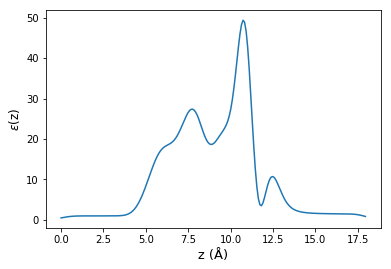

12/12/2018 05:54:18 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162668|SlabEpsilonSawtoothWorkChain|compute_epsilon_profile]: SlabEpsilonSawtoothWorkChain completed succesfully


In [47]:
from aiida.work.run import run
from aiida.orm.data.parameter import ParameterData
from aiida.orm.data.structure import StructureData
from aiida.orm.data.array.kpoints import KpointsData
from aiida.orm.data.base import  Str, Bool, Float, Int
# from aiida_defects.epsilon.slabepsilon import *

inputfile='lton_slab_2.cif'


from pymatgen.io import cif,aiida
from pymatgen.io.aiida import AiidaStructureAdaptor

structure_mg= cif.Structure.from_file(str(inputfile))
aiida_structure_adaptor = AiidaStructureAdaptor()
structure_sd = aiida_structure_adaptor.get_structuredata(structure_mg)
codename="pw_5.1@ubelix"
code_pp="pp_5.1@ubelix"
pseudo_family='SSSP'
#defect_position = ArrayData()
#defect_position.set_array("position", np.array([0., 0., 0.]))
defect_charge= 2.
epsilon_r =  2.



options={
        'resources': {
            'num_machines': 1,
            #'num_mpiprocs_per_machine': 1,
        },
         'max_wallclock_seconds' : 3600,
         #'custom_scheduler_commands' : u"#SBATCH --partition=all",
         #'custom_scheduler_commands' : u"#SBATCH --account=dcb",
         'custom_scheduler_commands' : u"#SBATCH --partition=empi",

        }

settings={}

kpoints = KpointsData()
kpoints.set_kpoints_mesh([8, 8, 1])

parameters = {
        'CONTROL': {
            'restart_mode': 'from_scratch',
            #'tstress': True,
            #'tprnfor' : True,
            'nstep' : 500,
            'etot_conv_thr' : 1.0e-6,
            'forc_conv_thr' : 1.0e-3,
            'tefield'      : True,
            'dipfield'  : True
        },
        'SYSTEM': {
            'ecutwfc': 40.,
            'ecutrho': 320.,
            'occupations' : 'smearing',
            'degauss' : 0.01,
            #'edir'   : 3,
            #'emaxpos' : 0.75,
            #'eopreg': 0.01,
            #'eamp' : 0.005,

            #'starting_magnetization' : starting_magnetization,
        },
        'ELECTRONS': {
            'conv_thr': 1.e-15,
            'mixing_beta' : 0.6,
            'startingwfc' : 'atomic',
        },

    }

outputs=run(SlabEpsilonSawtoothWorkChain,
             structure=structure_sd,
             code_pw=Str(codename),
             code_pp=Str(code_pp),
             pseudo_family=Str(pseudo_family),
             kpoints=kpoints,
             parameters=ParameterData(dict=parameters),
             settings=ParameterData(dict=settings),
             options=ParameterData(dict=options),
             B_atom=Str("Ti"),
             magnetic_phase=Str("NM"),
             eamp=Float(0.001),
             eopreg = Float(0.01),
             emaxpos = Float(0.),
             edir = Int(3),
             epsilon_type=Str('high_frequency'),
           )


12/07/2018 02:42:23 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [161472|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e0]: Launching PpWorkChain for a FEF calculation with amplitude 0.0 a.u.. pk value 161476
12/07/2018 02:48:34 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [161472|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1]: Launching PpWorkChain for a FEF calculation with amplitude 0.001 a.u.. pk value 161505
12/07/2018 02:55:05 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [161472|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1_saw]: Launching PpWorkChain to compute the sawtooth potential. pk value 161521


0 -8.6084917275 -8.6084917275 0.0
1 -8.6084917275 -8.6084917275 0.0
2 -8.6084917275 -6.59785357 2.0106381575
3 -6.59785357 -6.59785357 0.0
4 -6.59785357 5.41275 12.01060357
5 5.41275 5.41275 0.0
6 5.41275 5.41275 0.0
7 5.41275 7.4233881575 2.0106381575
8 7.4233881575 7.4233881575 0.0


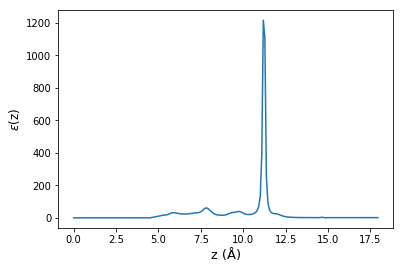

12/07/2018 02:56:02 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [161472|SlabEpsilonSawtoothWorkChain|compute_epsilon_profile]: SlabEpsilonSawtoothWorkChain completed succesfully


In [40]:
outputs=run(SlabEpsilonSawtoothWorkChain,
             structure=structure_sd,
             code_pw=Str(codename),
             code_pp=Str(code_pp),
             pseudo_family=Str(pseudo_family),
             kpoints=kpoints,
             parameters=ParameterData(dict=parameters),
             settings=ParameterData(dict=settings),
             options=ParameterData(dict=options),
             B_atom=Str("Ti"),
             magnetic_phase=Str("NM"),
             eamp=Float(0.001),
             eopreg = Float(0.01),
             emaxpos = Float(0.8),
             edir = Int(3),
             epsilon_type=Str('high_frequency'),
            sigma=Float(0.02)
           )

12/12/2018 04:28:42 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162594|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e0]: Launching PpWorkChain for a FEF calculation with amplitude 0.0 a.u.. pk value 162598
12/12/2018 04:52:00 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162594|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1]: Launching PpWorkChain for a FEF calculation with amplitude 0.001 a.u.. pk value 162623
12/12/2018 05:07:47 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162594|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1_saw]: Launching PpWorkChain to compute the sawtooth potential. pk value 162639


0 2.39719712346e-16 1.19859856173e-16 1.19859856173e-16
1 1.19859856173e-16 1.19859856173e-16 0.0
2 1.19859856173e-16 2.0106381575 2.0106381575
3 2.0106381575 2.0106381575 0.0
4 2.0106381575 4.0212582725 2.010620115
5 4.0212582725 4.0212582725 0.0
6 4.0212582725 4.0212582725 0.0
7 4.0212582725 6.03189643 2.0106381575
8 6.03189643 6.03189643 0.0


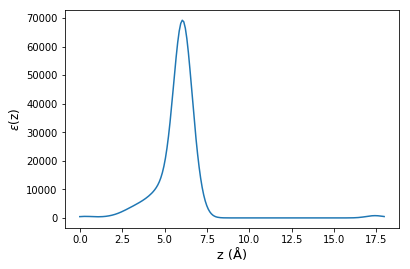

12/12/2018 05:08:50 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162594|SlabEpsilonSawtoothWorkChain|compute_epsilon_profile]: SlabEpsilonSawtoothWorkChain completed succesfully


In [46]:
outputs=run(SlabEpsilonSawtoothWorkChain,
             structure=structure_sd,
             code_pw=Str(codename),
             code_pp=Str(code_pp),
             pseudo_family=Str(pseudo_family),
             kpoints=kpoints,
             parameters=ParameterData(dict=parameters),
             settings=ParameterData(dict=settings),
             options=ParameterData(dict=options),
             B_atom=Str("Ti"),
             magnetic_phase=Str("NM"),
             eamp=Float(0.001),
             eopreg = Float(0.01),
             emaxpos = Float(0.),
             edir = Int(3),
             epsilon_type=Str('high_frequency'),
           )

12/12/2018 02:39:52 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162465|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e0]: Launching PpWorkChain for a FEF calculation with amplitude 0.0 a.u.. pk value 162469
12/12/2018 02:46:48 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162465|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1]: Launching PpWorkChain for a FEF calculation with amplitude 0.002 a.u.. pk value 162491
12/12/2018 02:53:49 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162465|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1_saw]: Launching PpWorkChain to compute the sawtooth potential. pk value 162507


0 2.39719712346e-16 1.19859856173e-16 1.19859856173e-16
1 1.19859856173e-16 1.19859856173e-16 0.0
2 1.19859856173e-16 2.0106381575 2.0106381575
3 2.0106381575 2.0106381575 0.0
4 2.0106381575 4.0212582725 2.010620115
5 4.0212582725 4.0212582725 0.0
6 4.0212582725 4.0212582725 0.0
7 4.0212582725 6.03189643 2.0106381575
8 6.03189643 6.03189643 0.0


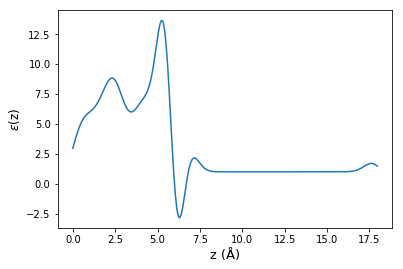

12/12/2018 02:55:18 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162465|SlabEpsilonSawtoothWorkChain|compute_epsilon_profile]: SlabEpsilonSawtoothWorkChain completed succesfully


In [44]:
inputfile='lton_2.cif'


from pymatgen.io import cif,aiida
from pymatgen.io.aiida import AiidaStructureAdaptor

structure_mg= cif.Structure.from_file(str(inputfile))
aiida_structure_adaptor = AiidaStructureAdaptor()
structure_sd = aiida_structure_adaptor.get_structuredata(structure_mg)
codename="pw_5.1@ubelix" 
code_pp="pp_5.1@ubelix"
pseudo_family='SSSP'
#defect_position = ArrayData()
#defect_position.set_array("position", np.array([0., 0., 0.]))
defect_charge= 2.
epsilon_r =  2.



options={
        'resources': {
            'num_machines': 1,
            #'num_mpiprocs_per_machine': 1,
        },
         'max_wallclock_seconds' : 3600,
         'custom_scheduler_commands' : u"#SBATCH --partition=all",
         'custom_scheduler_commands' : u"#SBATCH --account=dcb",
         #'custom_scheduler_commands' : u"#SBATCH --partition=empi",
        
        }

settings={}

kpoints = KpointsData()
kpoints.set_kpoints_mesh([8, 8, 1])


parameters = {
        'CONTROL': {
            'restart_mode': 'from_scratch',
            #'tstress': True,
            #'tprnfor' : True,
            'nstep' : 500,
            'etot_conv_thr' : 1.0e-6,
             'forc_conv_thr' : 1.0e-3,
            'tefield'      : True,
            'dipfield'  : True
        },
        'SYSTEM': {
            'ecutwfc': 40.,
            'ecutrho': 320.,
            'occupations' : 'smearing',
            'degauss' : 0.01,
            #'edir'   : 3,
            #'emaxpos' : 0.75,
            #'eopreg': 0.01,
            #'eamp' : 0.005,

            #'starting_magnetization' : starting_magnetization,
        },
        'ELECTRONS': {
            'conv_thr': 1.e-12,
            'mixing_beta' : 0.6,
            'startingwfc' : 'atomic',
        },

    }

#print structure_sd


outputs=run(SlabEpsilonSawtoothWorkChain,
             structure=structure_sd, 
             code_pw=Str(codename),
             code_pp=Str(code_pp),
             pseudo_family=Str(pseudo_family),
             kpoints=kpoints,
             parameters=ParameterData(dict=parameters),
             settings=ParameterData(dict=settings),
             options=ParameterData(dict=options), 
             B_atom=Str("Ti"),
             magnetic_phase=Str("NM"),
             eamp=Float(0.002)
#             #epsilon_type=Str('high_frequency'),
           )

12/12/2018 03:06:21 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162530|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e0]: Launching PpWorkChain for a FEF calculation with amplitude 0.0 a.u.. pk value 162534
12/12/2018 03:13:22 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162530|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1]: Launching PpWorkChain for a FEF calculation with amplitude 0.002 a.u.. pk value 162551
12/12/2018 03:20:18 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162530|SlabEpsilonSawtoothWorkChain|run_ppworkchain_e1_saw]: Launching PpWorkChain to compute the sawtooth potential. pk value 162567


0 2.39719712346e-16 1.19859856173e-16 1.19859856173e-16
1 1.19859856173e-16 1.19859856173e-16 0.0
2 1.19859856173e-16 2.0106381575 2.0106381575
3 2.0106381575 2.0106381575 0.0
4 2.0106381575 4.0212582725 2.010620115
5 4.0212582725 4.0212582725 0.0
6 4.0212582725 4.0212582725 0.0
7 4.0212582725 6.03189643 2.0106381575
8 6.03189643 6.03189643 0.0


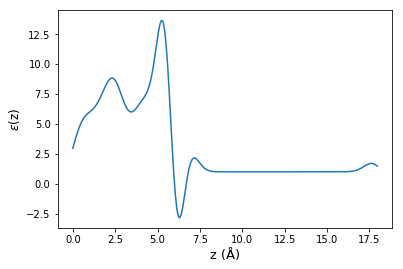

12/12/2018 03:21:21 PM, aiida.aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [162530|SlabEpsilonSawtoothWorkChain|compute_epsilon_profile]: SlabEpsilonSawtoothWorkChain completed succesfully


In [45]:

outputs=run(SlabEpsilonSawtoothWorkChain,
             structure=structure_sd, 
             code_pw=Str(codename),
             code_pp=Str(code_pp),
             pseudo_family=Str(pseudo_family),
             kpoints=kpoints,
             parameters=ParameterData(dict=parameters),
             settings=ParameterData(dict=settings),
             options=ParameterData(dict=options), 
             B_atom=Str("Ti"),
             magnetic_phase=Str("NM"),
             eamp=Float(0.002)
#             #epsilon_type=Str('high_frequency'),
           )